# Statistical Analysis of Trajectory Data

In addition to using the OAT library to analyze the data, we will also want to apply some common statistical analysis to the trajectory data provided by oxDNA so that we can compare the results to the output of our GNN. Note that for now I will report all the statistics in simulation units so they can be directly compared with GNN results. Specifically, we want to: 

* Obtain mean, standard deviation, min, max for each feature in the configuration file for each nucleotide over all time steps

* Obtain mean, standard deviation, min, max for the acceleration of each nucleotide over all time steps

* Compute mean, standard deviation, min, max for each feature in the configuration file over all nucleotides and all time steps

* Obtain mean, standard deviation, min, max for the acceleration over all nucleotides and over all time steps

* Compute mean, standard deviation, min, max for the total energy over all time steps

* Compute mean, standard deviation, min, max for the bounding box dimensions over all time steps

* Plot CoM position vs base vector as scatter plots for x, y, z

* Plot velocity vs angular vector as scatter plots for x, y, z

## Useful References:

* https://dna.physics.ox.ac.uk/index.php/Documentation
* https://dna.physics.ox.ac.uk/index.php/Input_options_of_the_previous_version
* https://dna.physics.ox.ac.uk/index.php/Model_introduction 

## Import Dataset

In [10]:
# import libraries
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [68]:
# import configuration data as np array
# Thanks Chris Kottke for code snippet

raw_data_path = "/home/emma/Documents/research/gnn-dna/dsdna-dataset/t1/sim_out/trajectory_sim.dat"
posAll = []
baseAll = []
baseNormalAll = []
velocityAll = []
angVelocityAll = []
bbAll = [] # bounding box data
energyAll = [] 

with open(raw_data_path, "r") as f:
    lines = f.readlines()
    pos = []
    base = []
    baseNormal = []
    velocity = []
    angVelocity = []
    
    for line in tqdm(lines):
        if "t =" in line:
            if len(pos) > 0:
                # save and reset the frames
                posAll.append(pos)
                pos = []
                baseAll.append(base)
                base = []
                baseNormalAll.append(baseNormal)
                baseNormal = []
                velocityAll.append(velocity)
                velocity = []
                angVelocityAll.append(angVelocity)
                angVelocity = []

        elif "b =" in line:
            line_list = [float(s) for s in line.split()[2:]]
            bbAll.append(line_list)
            
        elif "E =" in line:
            line_list = [float(s) for s in line.split()[2:]]
            energyAll.append(line_list)
            
        else:
            line_list = [float(s) for s in line.split()]
            pos.append(line_list[0:3])
            base.append(line_list[3:6])
            baseNormal.append(line_list[6:9])
            velocity.append(line_list[-6:-3])
            angVelocity.append(line_list[-3:])

if len(frame) > 0:
    posAll.append(pos)
    baseAll.append(base)
    baseNormalAll.append(baseNormal)
    velocityAll.append(velocity)
    angVelocityAll.append(angVelocity)

positions = [np.array(posAll, dtype=np.float32)]
num_particles = len(positions[0][0])
print("total number of particles", num_particles)

100%|█████████████████████████████████| 43000/43000 [00:00<00:00, 183996.92it/s]

total number of particles 40


## Trajectory Data Analysis 

### Function Definitions

In [78]:
def plotSampleTimeData(data, description):
    """
    Plots some sample trajectories over time.
    
    Inputs:
    
    data : np array size [t, n, c] where t = time steps, n = number of nucleotides, c = number of axes
    description : str describing the data
    """
    t = np.arange(0, data.shape[0])
    for i in range(0, data.shape[1], 8):
        plt.plot(t, data[:,i,0], label="{0}".format(i))
    plt.xlabel("Time")
    plt.ylabel("X {0}".format(description))
    plt.title("Sample {0} Data".format(description))
    plt.grid()
    plt.legend()
    plt.show()

In [104]:
def computeStatsPer(data):
    """
    Calculates mean, standard deviation, min, max for each nucleotide over all time steps for a given dataset.
    
    Inputs: 
    
    data : np array size [t, n, c] where t = time steps, n = number of nucleotides, c = number of axes
    """
    mean_per = np.mean(data, axis=0)
    std_per = np.std(data, axis=0)
    min_per = np.min(data, axis=0)
    max_per = np.max(data, axis=0)
    
    return mean_per, std_per, min_per, max_per

In [111]:
def computeStatsAll(mean_per, std_per, min_per, max_per):
    """
    Calculates mean, standard deviation, min, max for all nucleotides over all time steps for a given dataset.
    
    Inputs: 
    
    mean_per : np array size [n, c] where n = number of nucleotides, c = number of axes, contains mean data
    std_per : np array size [n, c] where n = number of nucleotides, c = number of axes, contains std data
    min_per : np array size [n, c] where n = number of nucleotides, c = number of axes, contains min data
    max_per : np array size [n, c] where n = number of nucleotides, c = number of axes, contains max data
    """

    mean_all = np.mean(mean_per, axis=0)
    std_all = np.std(std_per, axis=0)
    min_all = np.min(min_per, axis=0)
    max_all = np.max(max_per, axis=0)
    
    return mean_all, std_all, min_all, max_all

In [110]:
def computePlotStatsPer(data, description):
    """
    Calculates and plots mean, standard deviation, min, max for each nucleotide over all time steps for a given dataset.
    
    Inputs: 
    
    data : np array size [t, n, c] where t = time steps, n = number of nucleotides, c = number of axes
    description : str describing the data
    """
    
    mean_per, std_per, min_per, max_per = computeStatsPer(data)
    
    x = np.arange(0,mean_per.shape[0])
    
    # mean data
    plt.errorbar(x, mean_per[:,0], yerr=std_per[:,0], fmt="or", label="x")
    plt.errorbar(x, mean_per[:,1], yerr=std_per[:,1], fmt="og", label="y")
    plt.errorbar(x, mean_per[:,2], yerr=std_per[:,2], fmt="ob", label="z")
    
    # min max data
    plt.plot(x, min_per[:,0], "--r", label="min x")
    plt.plot(x, min_per[:,1], "--g", label="min y")
    plt.plot(x, min_per[:,2], "--b", label="min z")
    plt.plot(x, max_per[:,0], "-r", label="max x")
    plt.plot(x, max_per[:,1], "-g", label="max y")
    plt.plot(x, max_per[:,2], "-b", label="max z")

    plt.xlabel("Nucleotide")
    plt.ylabel("Mean {0}".format(description))
    plt.title("Mean {0} per Nucleotide".format(description))
    plt.legend()
    plt.grid()
    plt.show()

In [115]:
def computePlotStatsAll(data, description):
    """
    Calculates and plots mean, standard deviation, min, max for each nucleotide over all time steps for a given dataset.
    
    Inputs: 
    
    data : np array size [t, n, c] where t = time steps, n = number of nucleotides, c = number of axes
    description : str describing the data
    """
        
    mean_per, std_per, min_per, max_per = computeStatsPer(data)
    mean_all, std_all, min_all, max_all = computeStatsAll(mean_per, std_per, min_per, max_per)
    
    x = ("x", "y", "z")
    plt.errorbar(x, mean_all, yerr=std_all, fmt="ob", label="mean")
    plt.plot(x, min_all, label="min")
    plt.plot(x, max_all, label="max")
    plt.xlabel("Axis")
    plt.ylabel("Mean {0}".format(description))
    plt.title("Mean {0} for all Nucleotides".format(description))
    plt.grid()
    plt.legend()
    plt.show()

### Apply Functions to Data

In [87]:
posAll = np.array(posAll)
baseAll = np.array(baseAll)
baseNormalAll = np.array(baseNormalAll)
velocityAll = np.array(velocityAll)
angVelocityAll = np.array(angVelocityAll)

print(posAll.shape)
print(baseAll.shape)
print(baseNormalAll.shape)
print(velocityAll.shape)
print(angVelocityAll.shape)

(1000, 40, 3)
(1000, 40, 3)
(1000, 40, 3)
(1000, 40, 3)
(1000, 40, 3)


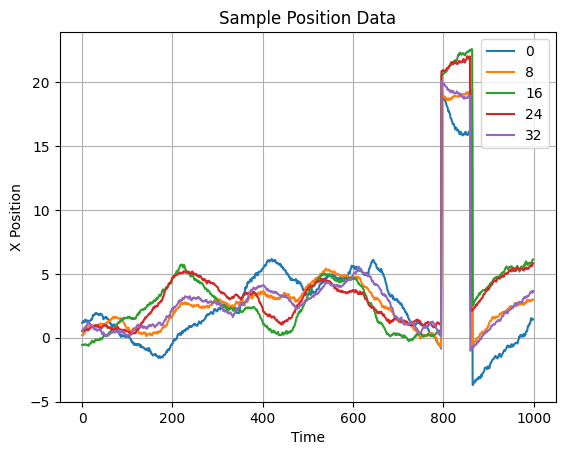

In [80]:
plotSampleTimeData(posAll, "Position")

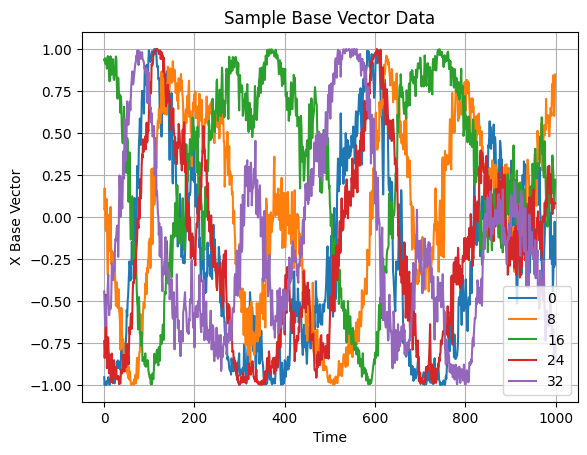

In [82]:
plotSampleTimeData(baseAll, "Base Vector")

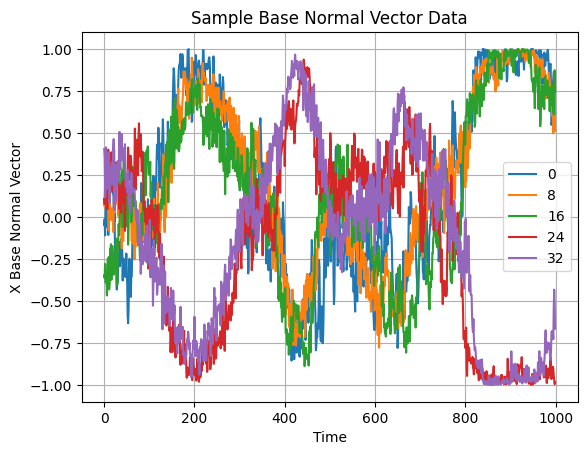

In [84]:
plotSampleTimeData(baseNormalAll, "Base Normal Vector")

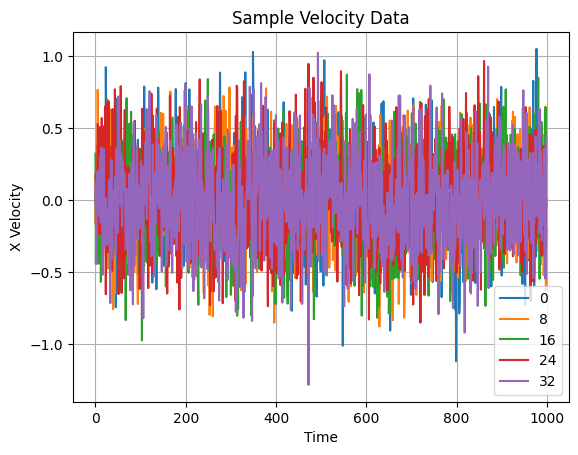

In [85]:
plotSampleTimeData(velocityAll, "Velocity")

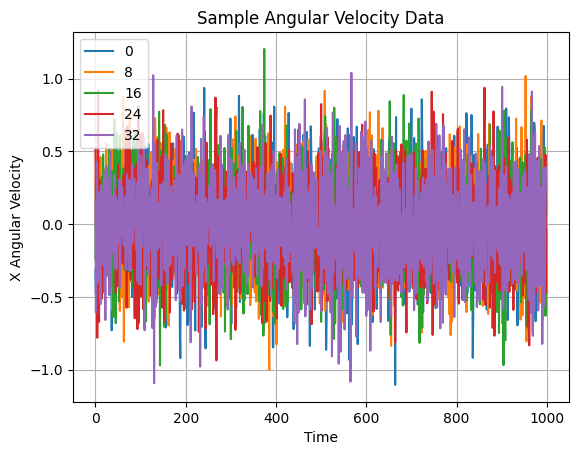

In [86]:
plotSampleTimeData(angVelocityAll, "Angular Velocity")

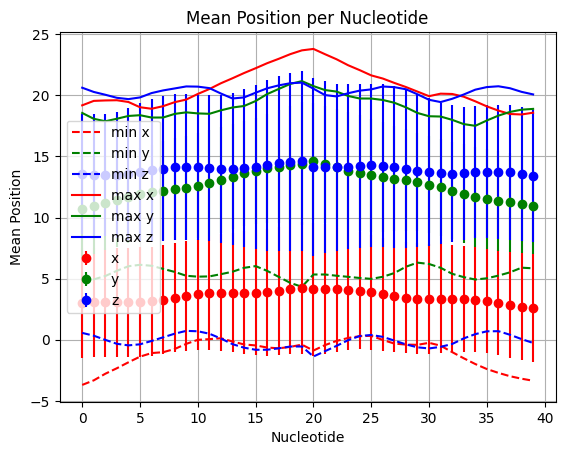

In [98]:
computePlotStatsPer(posAll, "Position")

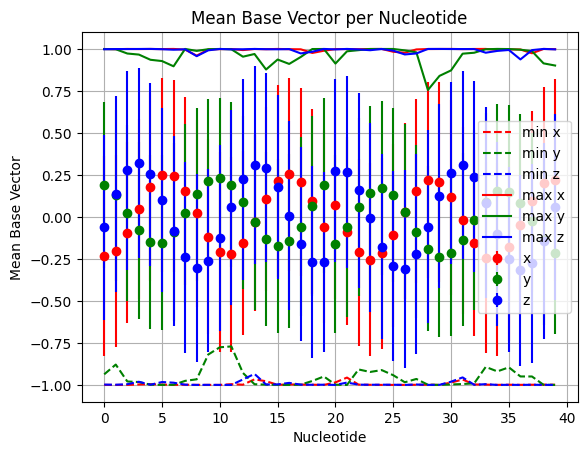

In [108]:
computePlotStatsPer(baseAll, "Base Vector")

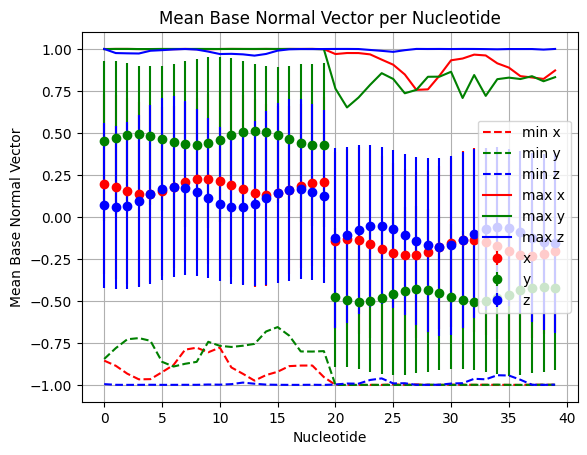

In [101]:
computePlotStatsPer(baseNormalAll, "Base Normal Vector")

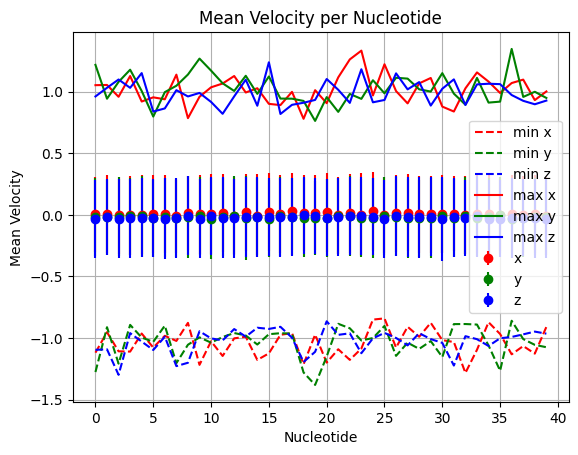

In [102]:
computePlotStatsPer(velocityAll, "Velocity")

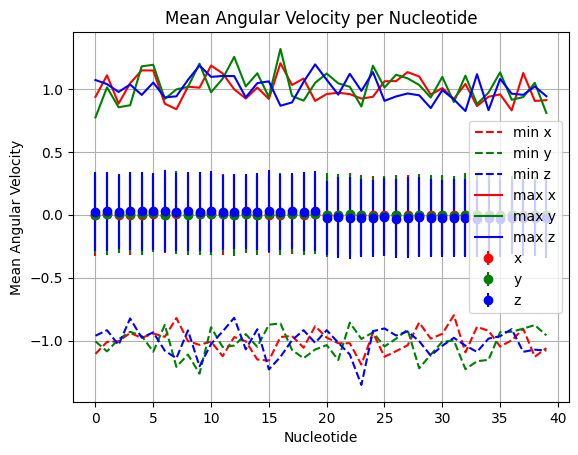

In [113]:
computePlotStatsPer(angVelocityAll, "Angular Velocity")

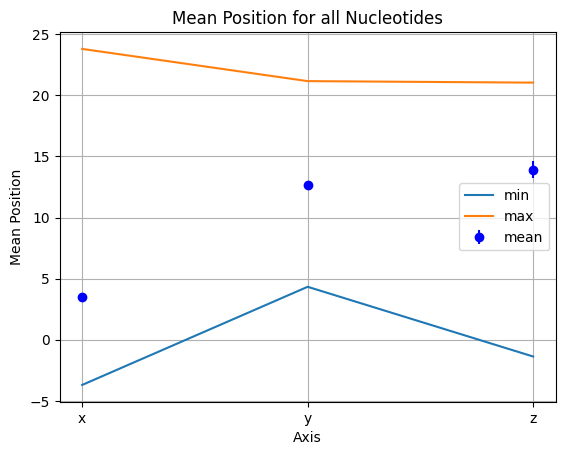

In [117]:
computePlotStatsAll(posAll, "Position")

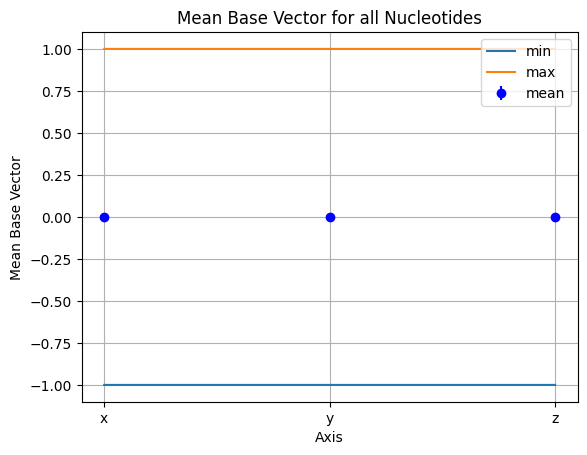

In [118]:
computePlotStatsAll(baseAll, "Base Vector")

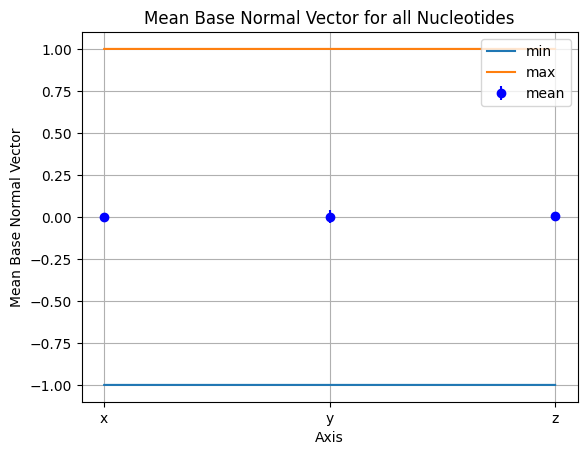

In [119]:
computePlotStatsAll(baseNormalAll, "Base Normal Vector")

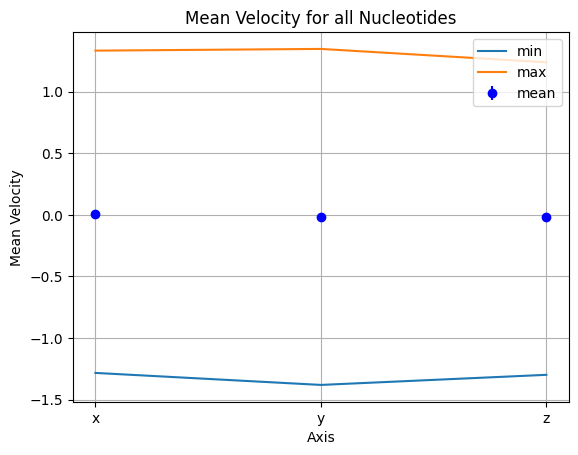

In [120]:
computePlotStatsAll(velocityAll, "Velocity")

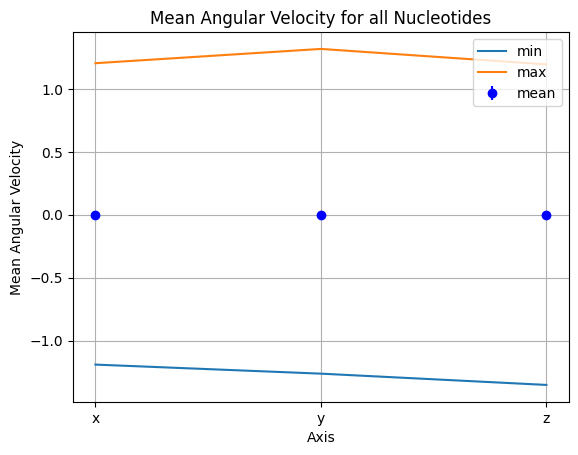

In [121]:
computePlotStatsAll(angVelocityAll, "Angular Velocity")

## Acceleration Data Analysis

In [122]:
velocityAll.shape

(1000, 40, 3)

In [131]:
# stats over accln
dt = 0.005
acclnAll = []
angAcclnAll = []

# iterate over nucleotides
# velocityAll = [t, n, c]
for i in range(velocityAll.shape[1]):
    accln = []
    angAccln = []
        
    # iterate over time steps
    for j in range(velocityAll.shape[0]-1):

        v_curr = velocityAll[j, i, :]
        v_next = velocityAll[j+1, i, :]
        a = (v_next - v_curr) / dt
        accln.append(a)

        av_curr = angVelocityAll[j, i, :]
        av_next = angVelocityAll[j+1, i, :]
        av = (av_next - av_curr) / dt
        angAccln.append(av)

    acclnAll.append(accln)
    angAcclnAll.append(angAccln)

In [132]:
_acclnAll = np.array(acclnAll)
acclnAll = np.reshape(_acclnAll, (_acclnAll.shape[1], _acclnAll.shape[0], _acclnAll.shape[2]))
_angAcclnAll = np.array(angAcclnAll)
angAcclnAll = np.reshape(_angAcclnAll, (_angAcclnAll.shape[1], _angAcclnAll.shape[0], _angAcclnAll.shape[2]))
print(acclnAll.shape)
print(angAcclnAll.shape)

(999, 40, 3)
(999, 40, 3)


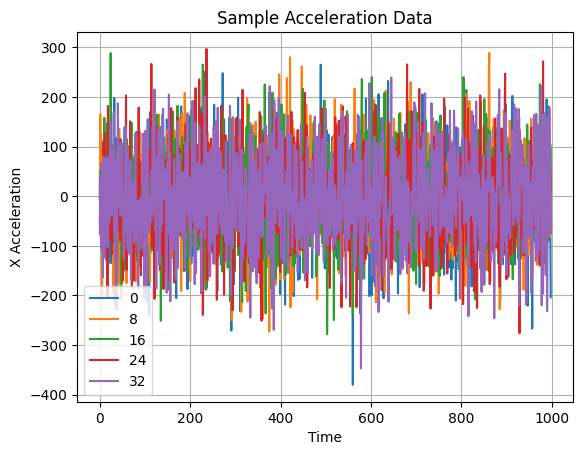

In [135]:
plotSampleTimeData(acclnAll, "Acceleration")

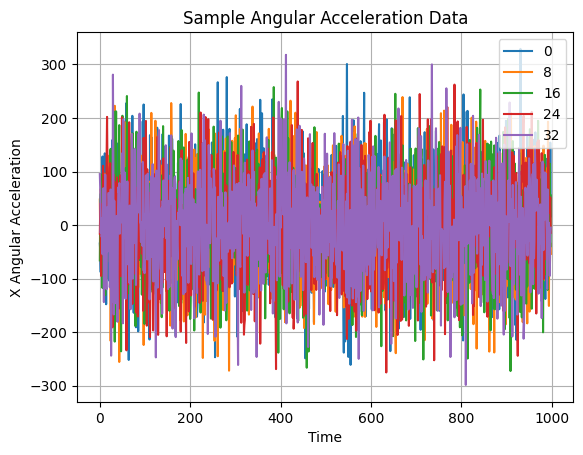

In [136]:
plotSampleTimeData(angAcclnAll, "Angular Acceleration")

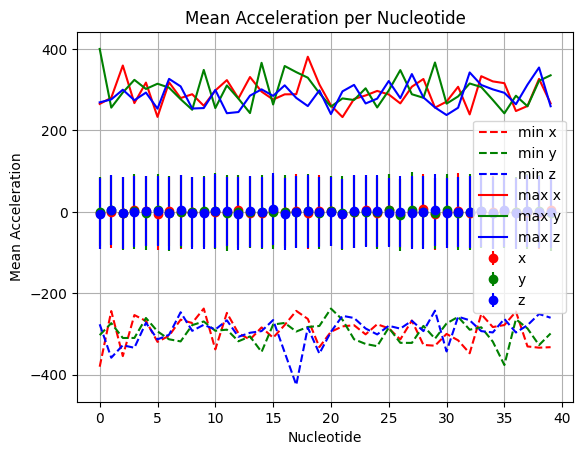

In [137]:
computePlotStatsPer(acclnAll, "Acceleration")

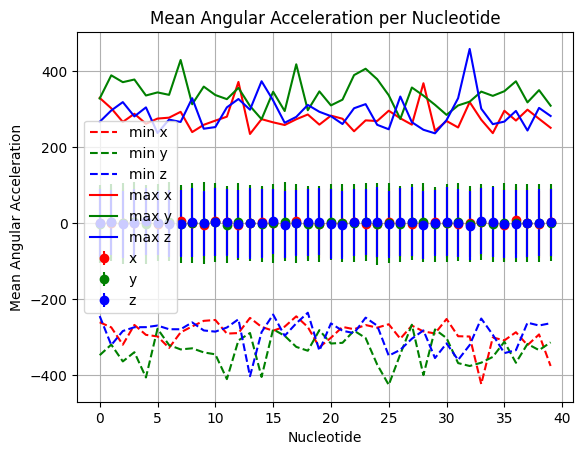

In [139]:
computePlotStatsPer(angAcclnAll, "Angular Acceleration")

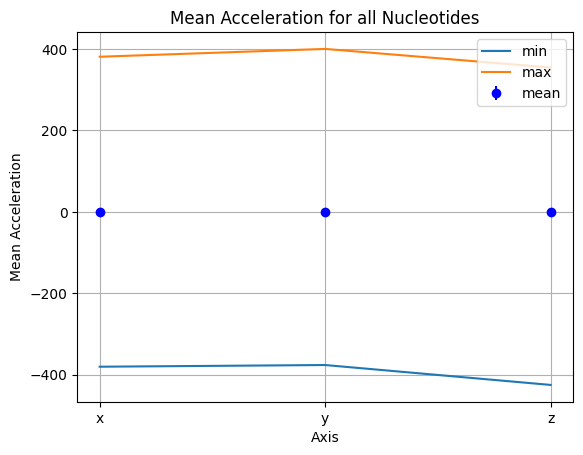

In [140]:
computePlotStatsAll(acclnAll, "Acceleration")

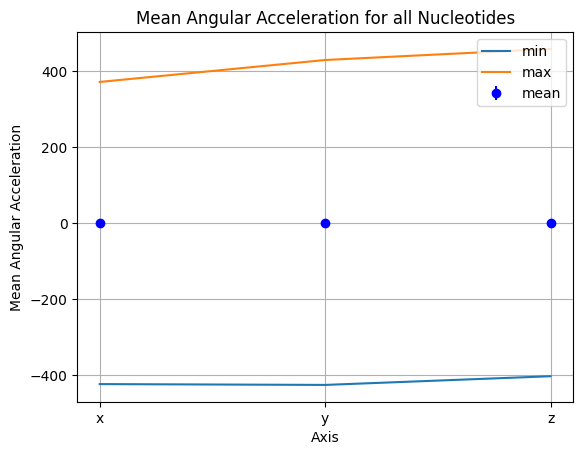

In [142]:
computePlotStatsAll(angAcclnAll, "Angular Acceleration")

## Energy Data Analysis

In [145]:
_energyAll = np.array(energyAll)
energyAll = _energyAll[:, 0] # E = Etot U K -- we just want Etot
energyAll.shape

(1000,)

In [ ]:
# stats for bounding box

In [ ]:
# compare position data

In [ ]:
# compare velocity data